## Prompt vs. Pre-Train/Fine-Tune Methods in Text Classificaton ##
#### Installations and Imports

In [ ]:
%pip install transformers
%pip install datasets
%pip install openprompts
%pip install accelerate -U
%pip install transformers==4.19.0

In [1]:
import copy
import torch
import numpy as np
import pandas as pd

from datasets import load_dataset, Dataset, concatenate_datasets

from transformers import (
    Trainer,
    TrainingArguments,
    BertForTokenClassification,
    BertForSequenceClassification,
    DataCollatorWithPadding,
    AutoTokenizer,
    AdamW
)


from openprompt.data_utils import InputExample
from openprompt.plms import load_plm
from openprompt.prompts import ManualTemplate, ManualVerbalizer
from openprompt import PromptDataLoader, PromptForClassification

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

use_cuda = torch.cuda.is_available()

C:\Users\vjay1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Text Classification ##

#### Load and format data ####

In [2]:
dataset = load_dataset('glue', 'sst2')

seed = 0

## Keep only 100 of the training data to speed up preprocessing/tokenization
dataset['train'] = dataset['train'].shuffle(seed = seed).select(range(1000))
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [3]:
## Separate the positives and negatives in training to ensure balanced samples.
dataset['pos_train'] = dataset['train'].filter(lambda x: x['label']==1)
dataset['neg_train'] = dataset['train'].filter(lambda x: x['label']==0)

In [4]:
# We will try different samples evenly split between classes
shot_increments = 5
sample_sizes = [2**i for i in range(4, 4 + shot_increments)]
sample_sizes

[16, 32, 64, 128, 256]

## Head Based fine-tuning ##

In [5]:
## Instantiate a Bert Tokenizer and tokenize the dataset

def tokenize_function(example):
    return tokenizer(example['sentence'], truncation = True)

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
tokenized_datasets = dataset.map(tokenize_function, batched= True)

# rename columns and convert tokenized dataset to pytorch format
tokenized_datasets = tokenized_datasets.remove_columns(["sentence", "idx"])
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets.set_format("torch")
tokenized_datasets['train'].column_names

Map: 100%|██████████| 872/872 [00:00<00:00, 11757.29 examples/s]


['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [6]:
## Define the accuracy metric

def compute_acc(eval_preds):
    preds = np.argmax(eval_preds.predictions, axis=-1)
    labels = eval_preds.label_ids
    acc = sum([int(i==j) for i,j in zip(preds, labels)])/len(labels)
    return acc

In [7]:
## "Zero-shot" i.e. the head has random weights and no training is done

training_args = TrainingArguments("trainer")
finetune_model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)
if use_cuda:
    finetune_model = finetune_model.cuda()

trainer = Trainer(
    finetune_model,
    training_args,
    train_dataset = tokenized_datasets['train'],
    tokenizer = tokenizer
)

## Skip training of the Trainer object for zero-shot
preds = trainer.predict(tokenized_datasets['validation'])
acc = compute_acc(preds)
finetune_scores = [acc]
print(finetune_scores)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

[0.4908256880733945]


In [8]:
## Now generate a learning curve. loop over different values of k (total samples)
# and calculate accuracy for each

for k in sample_sizes:
    train_sample = concatenate_datasets([tokenized_datasets['pos_train'].select(range(k)),
                                         tokenized_datasets['neg_train'].select(range(k))])
    training_args = TrainingArguments('trainer')
    model = copy.deepcopy(finetune_model)
    if use_cuda:
        model = model.cuda()

        trainer = Trainer(
            model,
            training_args,
            train_dataset = train_sample,
            # data_collator = data_collator,
            tokenizer = tokenizer
        )

    trainer.train()
    preds = trainer.predict(tokenized_datasets['validation'])
    acc = compute_acc(preds)
    finetune_scores.append(acc)
    print(finetune_scores)
    torch.cuda.empty_cache()                                                                                 

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
100%|██████████| 109/109 [00:11<00:00,  9.69it/s]
C:\Users\vjay1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 32
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12
1

{'train_runtime': 2.4642, 'train_samples_per_second': 38.959, 'train_steps_per_second': 4.87, 'train_loss': 0.6141129732131958, 'epoch': 3.0}


100%|██████████| 109/109 [00:04<00:00, 26.60it/s]PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
100%|██████████| 109/109 [00:04<00:00, 24.53it/s]
***** Running training *****
  Num examples = 64
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


[0.4908256880733945, 0.46788990825688076]


100%|██████████| 24/24 [00:04<00:00,  6.26it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 24/24 [00:04<00:00,  5.83it/s]
***** Running Prediction *****
  Num examples = 872
  Batch size = 8


{'train_runtime': 4.1381, 'train_samples_per_second': 46.398, 'train_steps_per_second': 5.8, 'train_loss': 0.6881643931070963, 'epoch': 3.0}


 98%|█████████▊| 107/109 [00:04<00:00, 25.61it/s]

[0.4908256880733945, 0.46788990825688076, 0.5103211009174312]


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
100%|██████████| 109/109 [00:04<00:00, 23.89it/s]
***** Running training *****
  Num examples = 128
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48
100%|██████████| 48/48 [00:09<00:00,  5.59it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 48/48 [00:09<00:00,  5.00it/s]
***** Running Prediction *****
  Num examples = 872
  Batch size = 8


{'train_runtime': 9.6151, 'train_samples_per_second': 39.937, 'train_steps_per_second': 4.992, 'train_loss': 0.6012775500615438, 'epoch': 3.0}


 99%|█████████▉| 108/109 [00:04<00:00, 24.77it/s]PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
100%|██████████| 109/109 [00:04<00:00, 25.29it/s]
***** Running training *****
  Num examples = 256
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 96


[0.4908256880733945, 0.46788990825688076, 0.5103211009174312, 0.805045871559633]


100%|██████████| 96/96 [00:16<00:00,  6.18it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 96/96 [00:16<00:00,  5.70it/s]
***** Running Prediction *****
  Num examples = 872
  Batch size = 8


{'train_runtime': 16.8777, 'train_samples_per_second': 45.504, 'train_steps_per_second': 5.688, 'train_loss': 0.3589279254277547, 'epoch': 3.0}


 99%|█████████▉| 108/109 [00:04<00:00, 26.12it/s]PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
100%|██████████| 109/109 [00:04<00:00, 26.12it/s]
***** Running training *****
  Num examples = 512
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 192


[0.4908256880733945, 0.46788990825688076, 0.5103211009174312, 0.805045871559633, 0.8681192660550459]


100%|██████████| 192/192 [00:34<00:00,  5.80it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 192/192 [00:34<00:00,  5.63it/s]
***** Running Prediction *****
  Num examples = 872
  Batch size = 8


{'train_runtime': 34.1428, 'train_samples_per_second': 44.988, 'train_steps_per_second': 5.623, 'train_loss': 0.2959648172060649, 'epoch': 3.0}


 99%|█████████▉| 108/109 [00:04<00:00, 23.07it/s]

[0.4908256880733945, 0.46788990825688076, 0.5103211009174312, 0.805045871559633, 0.8681192660550459, 0.8532110091743119]


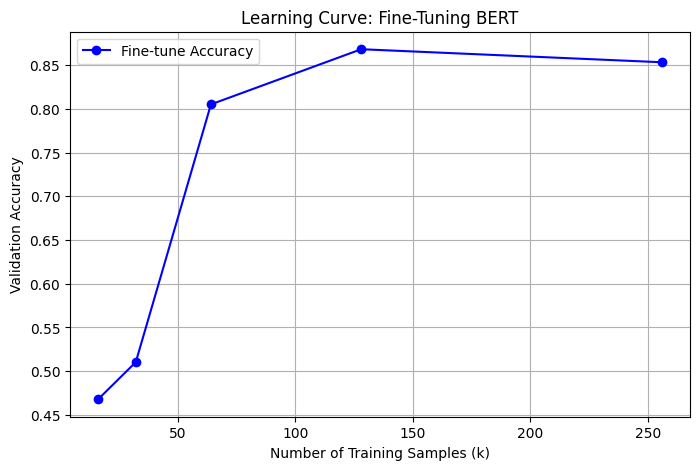

In [9]:
## Plot the learning curve
plt.figure(figsize=(8, 5))  # Set figure size

plt.plot(sample_sizes, finetune_scores[1:], marker='o', linestyle='-', color='b', label='Fine-tune Accuracy')

# Formatting
plt.xlabel("Number of Training Samples (k)")
plt.ylabel("Validation Accuracy")
plt.title("Learning Curve: Fine-Tuning BERT")
plt.legend()
plt.grid(True)  # Add grid for better readability

# Show the plot
plt.show()

## Prompt Based fine tuning

In [10]:
## Create a dataset of openprompt Inputexamples from the training data
prompt_dataset = {}
for split in ['pos_train', 'neg_train', 'validation', 'test']:
    prompt_dataset[split] = []
    for data in dataset[split]:
        input_example = InputExample(text_a = data['sentence'], label = int(data['label']), guid = data['idx'])
        prompt_dataset[split].append(input_example)

print(prompt_dataset['pos_train'][0])
print(prompt_dataset['neg_train'][0])        

{
  "guid": 24073,
  "label": 1,
  "meta": {},
  "text_a": "a wonderful , ghastly film ",
  "text_b": "",
  "tgt_text": null
}

{
  "guid": 39409,
  "label": 0,
  "meta": {},
  "text_a": "empty stud knockabout ",
  "text_b": "",
  "tgt_text": null
}



In [11]:
## Load the BERT model
plm, tokenizer, model_config, WrapperClass = load_plm("bert", "bert-base-cased")

## Create the prompt template
template_text = '{"placeholder": "text_a"} it is {"mask"} .'
template = ManualTemplate(tokenizer=tokenizer, text=template_text)

## Create a wrapped tokenizer
wrapped_tokenizer = WrapperClass(max_seq_length=128, decoder_max_length=3, tokenizer=tokenizer, truncate_method="head")

## Define your verbalizer with desired vocabulatary mapping to pos and neg
verbalizer = ManualVerbalizer(tokenizer, num_classes=2,
                              label_words=[['terrible'], ['great']])

## Generate a testing dataloader
val_dataloader = PromptDataLoader(prompt_dataset['validation'], template, tokenizer=tokenizer,
                                  tokenizer_wrapper_class=WrapperClass, batch_size=4)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at C:\Users\vjay1/.cache\huggingface\transformers\a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/pytorch_model.bin from c

In [12]:
## Define the accuracy metric

def evaluate(model, val_dataloader):
    model.eval()
    allpreds = []
    alllabels = []
    with torch.no_grad():
        for step, inputs in enumerate(val_dataloader):
            if use_cuda:
                inputs = inputs.cuda()
            logits = model(inputs)
            labels = inputs['label']
            alllabels.extend(labels.cpu().tolist())
            allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
    acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
    return acc

In [13]:
## ** Zero-shot testing **
## Run the evaluation set against the prompt model before any finetuning
## This is equivalent to normal prompt-based inference, relying just on
## the weights tuned into the model and not on any modifications

prompt_model = PromptForClassification(plm = copy.deepcopy(plm), template=template, verbalizer= verbalizer)
prompt_model = prompt_model.cuda()
prompt_scores = [evaluate(prompt_model, val_dataloader)]
prompt_scores

[0.680045871559633]

In [14]:
## Now generate a learning curve. loop over different values of k (total samples)
## and calculate accuracy for each

for k in sample_sizes:
    train_sample = prompt_dataset['pos_train'][:k] + prompt_dataset['neg_train'][:k]
    train_dataloader = PromptDataLoader(train_sample, template, tokenizer=tokenizer,
                                    tokenizer_wrapper_class=WrapperClass, shuffle=True,
                                    batch_size=4, seed=seed)

    prompt_model = PromptForClassification(plm=copy.deepcopy(plm), template=template,
                                         verbalizer=verbalizer, freeze_plm=False)
    prompt_model = prompt_model.cuda()

    loss_func = torch.nn.CrossEntropyLoss()
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
      {'params': [p for n, p in prompt_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
      {'params': [p for n, p in prompt_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

    for epoch in range(5):
        tot_loss = 0
        for step, inputs in enumerate(train_dataloader):
            if use_cuda:
                inputs = inputs.cuda()
            logits = prompt_model(inputs)
            labels = inputs['label']
            loss = loss_func(logits, labels)
            loss.backward()
            tot_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()

    accuracy = evaluate(prompt_model, val_dataloader)
    prompt_scores.append(accuracy)
    print(prompt_scores)
    torch.cuda.empty_cache()

tokenizing: 32it [00:00, 992.87it/s]
C:\Users\vjay1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[0.680045871559633, 0.805045871559633]


tokenizing: 64it [00:00, 1477.97it/s]
C:\Users\vjay1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[0.680045871559633, 0.805045871559633, 0.819954128440367]


tokenizing: 128it [00:00, 1045.08it/s]
C:\Users\vjay1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[0.680045871559633, 0.805045871559633, 0.819954128440367, 0.8463302752293578]


tokenizing: 256it [00:00, 1230.13it/s]
C:\Users\vjay1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[0.680045871559633, 0.805045871559633, 0.819954128440367, 0.8463302752293578, 0.8474770642201835]


tokenizing: 512it [00:00, 1271.10it/s]
C:\Users\vjay1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[0.680045871559633, 0.805045871559633, 0.819954128440367, 0.8463302752293578, 0.8474770642201835, 0.8612385321100917]


## Plot the results ##

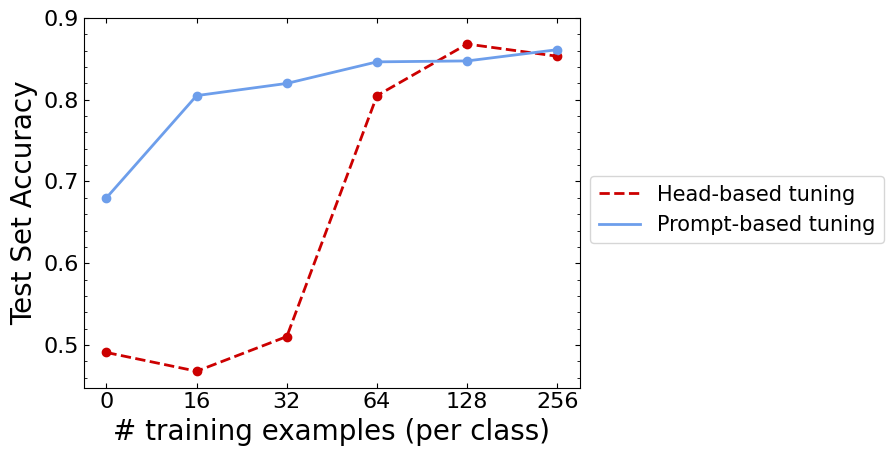

In [19]:
# plot the prompt-based training and pre-train/finetuning learning curves
# against each other

fig1 = plt.figure()
ax11 = fig1.add_subplot(111)

x = [0] + sample_sizes
ax11.plot(range(len(x)), finetune_scores, color='#cc0000', lw=2, ls='--', label='Head-based tuning')
ax11.scatter(range(len(x)), finetune_scores, color='#cc0000')
ax11.plot(range(len(x)), prompt_scores, color='#6d9eeb', lw=2, label='Prompt-based tuning')
ax11.scatter(range(len(x)), prompt_scores, color='#6d9eeb')
ax11.set_xticks(range(len(x)))
ax11.set_xticklabels(x,fontsize=16)
ax11.set_xlabel('# training examples (per class)',fontsize=20)

ax11.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
ax11.set_yticklabels(['0.5', '0.6', '0.7', '0.8', '0.9'],fontsize=16)
ax11.set_ylabel('Test Set Accuracy',fontsize=20)

ax11.xaxis.set_ticks_position('both')
ax11.tick_params(axis='x', which='major', direction='in')
ax11.tick_params(axis='x', which='minor', direction='in')
ax11.yaxis.set_ticks_position('both')
ax11.tick_params(axis='y', which='major', direction='in')
ax11.tick_params(axis='y', which='minor', direction='in')

plt.gca().yaxis.set_minor_locator(MultipleLocator(0.02))

ax11.legend(fontsize=15, loc = 'upper left', bbox_to_anchor=(1,0.6))